# Introduction

## Strategy:

* We sell Puts, because implied volatility is systematically higher than realized and skewed incorrectly (but underestimating tail risks)
* We choose the stocks based on high Free Cash Flow characteristic
* We choose strike based on Free Cash Flow characteristic
* We use VIX to adjust choices...somehow

## Open Key Questions:

* How exactly do we use VIX?
* Do we collateralize our Puts fully, or do we leverage?
* What do we specify?
    * Moneyness
    * Delta
    * Premium collected

## Probably answered Key Questions:

* Which maturity Puts do we buy?
    * 1 month
* Do we exit the Put Positions, or do we let them run to maturity?
    * We don't exit, we let them run to maturity
* What do we do with our profits/losses
    * We don't reinvest, but maintain our target notional

## Open Issues

* In the currently detailled approach below, we do not use FCF for strike selection, but rather VIX
    * that is different than the rough strategy described above

# Theoretical Approach

## Model Parameters: 

Sign | Meaning
--- | :---
$N$ | Collateral we are willing to invest into our strategy
$\phi$ | Collateral Coverage ratio of Puts $$0 < \phi \le 1$$
$\alpha$ | Quantile of stocks we allow into our portfolio $$0 < \alpha \le 1$$
$\theta_0,\theta_1$ | Relationhip between VIX and the appropriate strike choice

## Input Data required

All Parameters listed here are time-series, i.e. they are different for each time t.

Sign | Meaning
--- | :---
$\sigma_{i}^c$ | Implied volatility of each stock
$\Delta_{i}^P$ | Delta of the Put sale of each stock
$\mathbf F$ | Vector containing free Cashflows for all considered stocks
$VIX$ | Value of VIX

In order to evaluate the success of our strategy, we also need the following:

Sign | Meaning
--- | :---
$\mathbf Y$ | Matrix containing the premiums for all assets and strikes
$\mathbf P$ | Vector containing the prices of all stocks

## Strategy Components

### Stock Selection

$S$ is the set of stocks we have chosen to sell Puts for this period. We include an asset if its FCF is within the top $\alpha$-percentile of all assets.
\begin{align}
F_i \ge Q_\alpha(F) \implies i \in S
\end{align}

### Strike Selection

We have the choice to specify one of the following in order to select the strike:
* moneyness
* delta
* premium

From Literature we know that VIX can be regarded as a sentiment analysis of the market, as opposed to an accurate forecast of future volatility.
We assume a useful relation between VIX and the appropriate strike selection.
For simplicity at the start, we further assume a linear relationship.

\begin{align}
\delta & = \theta_0 + \theta_1 * VIX
\end{align}

where $\delta$ is the Delta which had yielded the best result.
We regress $\delta$ from historical data. In any given period, all the Puts we sell will have the same delta.

$$\Delta_i^P = \delta \quad\forall i$$

### Put Weighting

From the selected stocks we construct our portfolio as a Minimum variance Portfolio. Ignoring Correlations, $w_{MinV} = w_{ERC}$.

Justification: *"The risk neutral weighting methodology tends to overweight the lower delta, lower volatility put sales in the portfolio leading to a higher Sharpe ratio, despite a modestly lower average return."
*

**Risk:**
*"We define risk as the implied volatility of each stock multiplied by the delta of the put sale of the same stock."*

\begin{align}
R_{i} & = \sigma_{i}^c * \Delta_{i}^P \\
RC_{i} & = w_{i} * R_i \\
RC_i & = RC_j \quad \forall i,j \in S
\end{align}

The Puts we sell expire after one month. A month is 21 trading days. Therefore, when we take on $\frac1{21}$ of our target portfolio notional, we will achieve our target after one month and maintain it by rolling over. This is adjusted by our desired coverage ratio.

\begin{align}
\sum_{i\in S} w_i = \frac{N}{21*\phi}
\end{align}

# Initialization

In [ ]:
import pandas as pd
import pandas_datareader as web
import pandas_datareader.tsp as tsp
import datetime as dt
import numpy as np
import time

from pandas_datareader.data import Options

%matplotlib inline

S&P 500 retrieved from wikipedia on 11 Nov 2017 and saved for convenience:

In [2]:
SP500_symbols = ['MMM', 'ABT', 'ABBV', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AMD', 'AAP', 'AES', 'AET', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'APC', 'ADI', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT', 'ADM', 'ARNC', 'AJG', 'AIZ', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BHGE', 'BLL', 'BAC', 'BK', 'BCR', 'BAX', 'BBT', 'BDX', 'BRK.B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BWA', 'BXP', 'BSX', 'BHF', 'BMY', 'AVGO', 'BF.B', 'CHRW', 'CA', 'COG', 'CDNS', 'CPB', 'COF', 'CAH', 'CBOE', 'KMX', 'CCL', 'CAT', 'CBG', 'CBS', 'CELG', 'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CHK', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'COO', 'GLW', 'COST', 'COTY', 'CCI', 'CSRA', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DLPH', 'DAL', 'XRAY', 'DVN', 'DLR', 'DFS', 'DISCA', 'DISCK', 'DISH', 'DG', 'DLTR', 'D', 'DOV', 'DWDP', 'DPS', 'DTE', 'DRE', 'DUK', 'DXC', 'ETFC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMR', 'ETR', 'EVHC', 'EOG', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ES', 'RE', 'EXC', 'EXPE', 'EXPD', 'ESRX', 'EXR', 'XOM', 'FFIV', 'FB', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FE', 'FISV', 'FLIR', 'FLS', 'FLR', 'FMC', 'FL', 'F', 'FTV', 'FBHS', 'BEN', 'FCX', 'GPS', 'GRMN', 'IT', 'GD', 'GE', 'GGP', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GS', 'GT', 'GWW', 'HAL', 'HBI', 'HOG', 'HRS', 'HIG', 'HAS', 'HCA', 'HCP', 'HP', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HPQ', 'HUM', 'HBAN', 'IDXX', 'INFO', 'ITW', 'ILMN', 'IR', 'INTC', 'ICE', 'IBM', 'INCY', 'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IRM', 'JEC', 'JBHT', 'SJM', 'JNJ', 'JCI', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'KMB', 'KIM', 'KMI', 'KLAC', 'KSS', 'KHC', 'KR', 'LB', 'LLL', 'LH', 'LRCX', 'LEG', 'LEN', 'LUK', 'LLY', 'LNC', 'LKQ', 'LMT', 'L', 'LOW', 'LYB', 'MTB', 'MAC', 'M', 'MRO', 'MPC', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MAT', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'MET', 'MTD', 'MGM', 'KORS', 'MCHP', 'MU', 'MSFT', 'MAA', 'MHK', 'TAP', 'MDLZ', 'MON', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MYL', 'NDAQ', 'NOV', 'NAVI', 'NTAP', 'NFLX', 'NWL', 'NFX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NLSN', 'NKE', 'NI', 'NBL', 'JWN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'ORLY', 'OXY', 'OMC', 'OKE', 'ORCL', 'PCAR', 'PKG', 'PH', 'PDCO', 'PAYX', 'PYPL', 'PNR', 'PBCT', 'PEP', 'PKI', 'PRGO', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'RL', 'PPG', 'PPL', 'PX', 'PCLN', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'PWR', 'QCOM', 'DGX', 'Q', 'RRC', 'RJF', 'RTN', 'O', 'RHT', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RHI', 'ROK', 'COL', 'ROP', 'ROST', 'RCL', 'CRM', 'SBAC', 'SCG', 'SLB', 'SNI', 'STX', 'SEE', 'SRE', 'SHW', 'SIG', 'SPG', 'SWKS', 'SLG', 'SNA', 'SO', 'LUV', 'SPGI', 'SWK', 'SBUX', 'STT', 'SRCL', 'SYK', 'STI', 'SYMC', 'SYF', 'SNPS', 'SYY', 'TROW', 'TPR', 'TGT', 'TEL', 'FTI', 'TXN', 'TXT', 'TMO', 'TIF', 'TWX', 'TJX', 'TMK', 'TSS', 'TSCO', 'TDG', 'TRV', 'TRIP', 'FOXA', 'FOX', 'TSN', 'UDR', 'ULTA', 'USB', 'UA', 'UAA', 'UNP', 'UAL', 'UNH', 'UPS', 'URI', 'UTX', 'UHS', 'UNM', 'VFC', 'VLO', 'VAR', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VIAB', 'V', 'VNO', 'VMC', 'WMT', 'WBA', 'DIS', 'WM', 'WAT', 'WEC', 'WFC', 'HCN', 'WDC', 'WU', 'WRK', 'WY', 'WHR', 'WMB', 'WLTW', 'WYN', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XL', 'XYL', 'YUM', 'ZBH', 'ZION', 'ZTS']

# Data Retrieval

## Getting VIX

In [5]:
vix = web.DataReader('^VIX', 'yahoo')

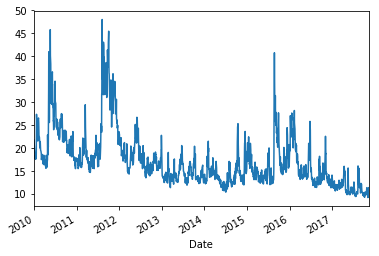

In [6]:
vix['Adj Close'].plot()

## Getting S&P 500

In [7]:
data = {}
problematic_symbols = []

This will query yahoo sequentially for 500 quotes and will therefore take a while.
Progress is displayed while working.

In [8]:
for i in range(len(SP500_symbols)):
    print(str(i) + '/'+ str(len(SP500_symbols)-1) + ' | ' + str(len(problematic_symbols)), end='\r')
    #time.sleep(5)
    try:
        data[SP500_symbols[i]] = web.DataReader(SP500_symbols[i], 'yahoo')
    except:
        problematic_symbols.append(SP500_symbols[i])

In [9]:
print(problematic_symbols)

['ALK', 'ARE', 'ALGN', 'LNT', 'GOOG', 'AMT', 'AME', 'AMGN', 'APH', 'ANTM', 'ADM', 'ADSK', 'BRK.B', 'BBY', 'BA', 'BF.B', 'CCL', 'CELG', 'CNC', 'CERN', 'SCHW', 'CI', 'CTAS', 'CMA', 'STZ', 'GLW', 'CSX', 'DVA', 'DAL', 'DVN', 'DXC', 'EMR', 'EXR', 'FDX', 'FISV', 'FLR', 'FCX', 'IT', 'GE', 'GS', 'GT', 'HAL', 'HOG', 'HIG', 'HCA', 'HOLX', 'HD', 'IBM', 'INCY', 'ISRG', 'LLL', 'MAS', 'MAT', 'MDT', 'MRK', 'MCHP', 'MSFT', 'TAP', 'MDLZ', 'MSI', 'NAVI', 'NWSA', 'JWN', 'NUE', 'PH', 'PDCO', 'PAYX', 'PNC', 'PPG', 'PHM', 'COL', 'STX', 'SRE', 'LUV', 'SRCL', 'STI', 'UAA', 'UAL', 'UNH', 'URI', 'UTX', 'V', 'VNO', 'WDC', 'WLTW', 'XRX', 'YUM', 'ZBH']


## Getting Nasdaq List of Symbols

In [13]:
nasdaq = web.nasdaq_trader.get_nasdaq_symbols()

## Getting Options

In [14]:
aapl = Options('AAPL', 'yahoo')
aapl.get_put_data()

,,,,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
Strike,Expiry,Type,Symbol,,,,,,,,,,,,,,,
47.5,2017-11-17,put,AAPL171117P00047500,0.01,0.00,0.04,0.000000,0.000000,15.0,1078.0,3.468751,AAPL,False,AAPL,174.67,2017-11-10 21:00:01,2017-06-03 03:54:53,"{'contractSymbol': 'AAPL171117P00047500', 'str..."
50.0,2017-11-17,put,AAPL171117P00050000,0.02,0.00,0.02,0.000000,0.000000,2.0,627.0,3.125002,AAPL,False,AAPL,174.67,2017-11-10 21:00:01,2017-07-06 14:50:01,"{'contractSymbol': 'AAPL171117P00050000', 'str..."
55.0,2017-11-17,put,AAPL171117P00055000,0.02,0.00,0.02,0.000000,0.000000,10.0,876.0,2.937503,AAPL,False,AAPL,174.67,2017-11-10 21:00:01,2017-06-03 03:54:53,"{'contractSymbol': 'AAPL171117P00055000', 'str..."
60.0,2017-11-17,put,AAPL171117P00060000,0.01,0.00,0.01,-0.010000,-50.000000,21.0,2124.0,2.562504,AAPL,False,AAPL,174.67,2017-11-10 21:00:01,2017-09-22 13:36:55,"{'contractSymbol': 'AAPL171117P00060000', 'str..."
65.0,2017-11-17,put,AAPL171117P00065000,0.02,0.00,0.01,-0.010000,-33.333336,7.0,2118.0,2.375004,AAPL,False,AAPL,174.67,2017-11-10 21:00:01,2017-10-06 14:28:56,"{'contractSymbol': 'AAPL171117P00065000', 'str..."
70.0,2017-11-17,put,AAPL171117P00070000,0.01,0.00,0.01,0.000000,0.000000,5.0,2344.0,2.187505,AAPL,False,AAPL,174.67,2017-11-10 21:00:01,2017-10-09 16:27:28,"{'contractSymbol': 'AAPL171117P00070000', 'str..."
75.0,2017-11-17,put,AAPL171117P00075000,0.01,0.00,0.02,0.000000,0.000000,7.0,1667.0,2.156255,AAPL,False,AAPL,174.67,2017-11-10 21:00:01,2017-09-28 14:49:02,"{'contractSymbol': 'AAPL171117P00075000', 'str..."
80.0,2017-11-17,put,AAPL171117P00080000,0.01,0.00,0.05,0.000000,0.000000,2.0,3806.0,2.171880,AAPL,False,AAPL,174.67,2017-11-10 21:00:01,2017-08-09 13:49:04,"{'contractSymbol': 'AAPL171117P00080000', 'str..."
85.0,2017-11-17,put,AAPL171117P00085000,0.01,0.00,0.02,0.000000,0.000000,7.0,1693.0,1.843751,AAPL,False,AAPL,174.67,2017-11-10 21:00:01,2017-09-28 14:50:55,"{'contractSymbol': 'AAPL171117P00085000', 'str..."


In [3]:
put_option = web.DataReader('AAPL171117C00020000', 'yahoo')

In [4]:
put_option

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-21,140.25,140.25,140.0,140.0,140.0,32


## Getting ETFs

In [15]:
nasdaq[nasdaq['ETF'].isin([True])]

,Nasdaq Traded,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
Symbol,,,,,,,,,,,
AADR,True,AdvisorShares Dorsey Wright ADR ETF,P,,True,100.0,False,NaN,AADR,AADR,False
AAXJ,True,iShares MSCI All Country Asia ex Japan Index Fund,Q,G,True,100.0,False,N,NaN,AAXJ,False
ACIM,True,SPDR MSCI ACWI IMI ETF,P,,True,100.0,False,NaN,ACIM,ACIM,False
ACSI,True,American Customer Satisfaction Core Alpha ETF,Z,,True,100.0,False,NaN,ACSI,ACSI,False
ACWF,True,iShares Edge MSCI Multifactor Global ETF,P,,True,100.0,False,NaN,ACWF,ACWF,False
ACWI,True,iShares MSCI ACWI Index Fund,Q,G,True,100.0,False,N,NaN,ACWI,False
ACWV,True,iShares Edge MSCI Min Vol Global ETF,Z,,True,100.0,False,NaN,ACWV,ACWV,False
ACWX,True,iShares MSCI ACWI ex US Index Fund,Q,G,True,100.0,False,N,NaN,ACWX,False
ADRA,True,BLDRS Asia 50 ADR Index Fund,Q,G,True,100.0,False,N,NaN,ADRA,False


## Getting Cashflow Data

GOOD F'ING QUESTION

# Experimental Data Analysis

In [16]:
stockIterator = iter (data.values())

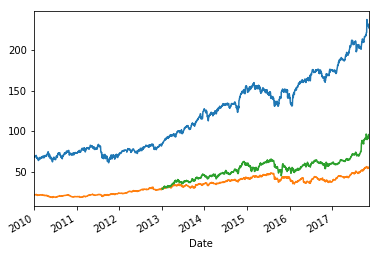

In [17]:
next (stockIterator)['Adj Close'].plot()
next (stockIterator)['Adj Close'].plot()
next (stockIterator)['Adj Close'].plot()

MMM
ABT
ABBV


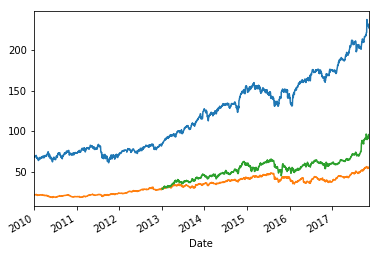

In [18]:
i=0
for key, value in data.items():
    print(key)
    value['Adj Close'].plot()
    i+=1
    if i>=3:
        sampleStock = value
        break

In [19]:
sampleStock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,34.919998,35.400002,34.099998,35.119999,29.421579,13767900
2013-01-03,35.000000,35.000000,34.160000,34.830002,29.178646,16739300
2013-01-04,34.619999,34.889999,34.250000,34.389999,28.810034,21372100
2013-01-07,34.150002,35.450001,34.150002,34.459999,28.868670,17897100
2013-01-08,34.290001,34.639999,33.360001,33.709999,28.240362,17863300
2013-01-09,33.610001,33.950001,33.610001,33.900002,28.399534,18800400
2013-01-10,33.660000,34.000000,33.330002,34.000000,28.483307,15658100
2013-01-11,33.590000,33.900002,33.349998,33.849998,28.695232,11191500
2013-01-14,34.009998,34.250000,33.799999,34.090000,28.898682,11584900


# Things to be discussed
## Yahoo is unable to process a bunch of fast requests

In [20]:
put_option = web.DataReader('AAPL', 'yahoo')
put_option = web.DataReader('AAPL', 'yahoo')
put_option = web.DataReader('AAPL', 'yahoo')
put_option = web.DataReader('AAPL', 'yahoo')
put_option = web.DataReader('AAPL', 'yahoo')
put_option = web.DataReader('AAPL', 'yahoo')
put_option = web.DataReader('AAPL', 'yahoo')
put_option = web.DataReader('AAPL', 'yahoo')
put_option = web.DataReader('AAPL', 'yahoo')
put_option = web.DataReader('AAPL', 'yahoo')
put_option = web.DataReader('AAPL', 'yahoo')
put_option = web.DataReader('AAPL', 'yahoo')
put_option = web.DataReader('AAPL', 'yahoo')
put_option = web.DataReader('AAPL', 'yahoo')

RemoteDataError: Unable to read URL: https://query1.finance.yahoo.com/v7/finance/download/AAPL?period1=1262300400&period2=1510527599&interval=1d&events=history&crumb=inubzDvy%5Cu002FaL

## Google API does not know all S&P500 stocks
As defined by wikipedia: https://en.wikipedia.org/wiki/List_of_S%26P_500_companies

In [21]:
web.DataReader('ABT', 'google')

RemoteDataError: Unable to read URL: http://www.google.com/finance/historical?q=ABT&startdate=Jan+01%2C+2010&enddate=Nov+12%2C+2017&output=csv